In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import keras_tuner as kt
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


## Building neural network model without PCA


In [2]:
#importing required data and performing first train test split using same metrics as previous models
diabetes_data = pd.read_csv("processed_data.csv")
diabetes_data = diabetes_data.drop(columns = "Unnamed: 0")
diabetes_data_predictors = diabetes_data.drop(columns="readmitted")
X, y = diabetes_data_predictors, diabetes_data["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [3]:
#performing undersampling similar to other previous models
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X = pd.concat([X_train, y_train], axis=1)

not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = int(len(readmitted) * 1.25),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])


y_train = downsampled.readmitted
X_train = downsampled.drop('readmitted', axis=1)

#second train test split to create model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [4]:
#defining a function to create neural network model to allow for hyperparameter tuning - optimized this code based on keras tutorial to optimize f1-score
def create_nn_model(lr=0.001, rate=0.5):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(rate), 
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(rate),
        Dense(1, activation='sigmoid')
    ])

#using focal_loss function as suggested by keras tutorial as binary cross entropy has very poor performance
    def focal_loss(gamma=2., alpha=0.25):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
            pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
        return loss

#optimzing model to prevent overfitting using Adam
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=focal_loss(),
                  metrics=['Precision', 'Recall', 'AUC'])
    
    return model

#setting hyperparameters for learning rate and loss rates
hparam = {"lr": [0.0001, 0.001], "rate": [0.4, 0.8]}

# Wrap the model in KerasClassifier to prepare for grid search for tuning hyperpaameters
nn_model = KerasClassifier(model=create_nn_model, verbose=0, lr=0.0001, rate=0.4)

#make scorer frwuired to optimize for grid search
scoring_dic = {'f1_macro': make_scorer(f1_score, average='macro')}

cv = KFold(4) 

#early stopping needed to prevent overfitting in case model doesnt need as many epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#perfomring grid search to get the best hyperparameters for the training set
gs = GridSearchCV(nn_model, hparam, scoring=scoring_dic, cv=cv, refit='f1_macro', verbose=1, return_train_score=True)
gs.fit(X_train, y_train.to_numpy(dtype=float), callbacks = [early_stopping])

print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)

#getting the best neural network model
nn_best_model = gs.best_estimator_

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model i

Best Parameters: {'lr': 0.001, 'rate': 0.4}
Best Score: 0.5353635219845206


In [5]:
#training model properly using best hyperparameters
best_params = gs.best_params_
best_nn_model = create_nn_model(lr=best_params['lr'], rate=best_params['rate'])

#using early stopping again to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#assigning class weights as without this f1 score is very low - needed even with undersampling technique
class_weights = {0: 1, 1: 7} 

#training neural network model
history = best_nn_model.fit(X_train, y_train.to_numpy(dtype=float), 
                            epochs=50, batch_size=32, validation_data=(X_val, y_val),
                            verbose=1, class_weight=class_weights)

Epoch 1/50


/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.4982 - Precision: 0.4454 - Recall: 0.4616 - loss: 0.3702 - val_AUC: 0.5896 - val_Precision: 0.5251 - val_Recall: 0.4437 - val_loss: 0.0430
Epoch 2/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.5189 - Precision: 0.4690 - Recall: 0.4514 - loss: 0.1935 - val_AUC: 0.5834 - val_Precision: 0.5360 - val_Recall: 0.3667 - val_loss: 0.0424
Epoch 3/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.5434 - Precision: 0.4760 - Recall: 0.4167 - loss: 0.1605 - val_AUC: 0.6020 - val_Precision: 0.5530 - val_Recall: 0.3405 - val_loss: 0.0420
Epoch 4/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.5764 - Precision: 0.5196 - Recall: 0.3814 - loss: 0.1560 - val_AUC: 0.6072 - val_Precision: 0.6085 - val_Recall: 0.2765 - val_loss: 0.0419
Epoch 5/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.5999 - Precision: 0.5519 - Recall: 0.3871 - loss: 0.1542 - val_AUC: 0.6145 - val_Precision: 0.6209 - val_Recall: 0.2454 - val_loss: 0.0418
Epoch 6/50


In [6]:
#evaluating model on testing dataset that has balanced class
y_pred = best_nn_model.predict(X_val)
y_pred_val = (y_pred > 0.5).astype(int)


#accuracy and classification report 
print("Test Accuracy:", accuracy_score(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
Test Accuracy: 0.6154618473895582
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69      3339
           1       0.59      0.41      0.49      2637

    accuracy                           0.62      5976
   macro avg       0.61      0.59      0.59      5976
weighted avg       0.61      0.62      0.60      5976



In [7]:
#evaluting performance of nn model on original testing set with real world class imbalance.
y_preddd = best_nn_model.predict(X_test)
y_pred_val_q = (y_preddd > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_val_q))

613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     17398
           1       0.18      0.40      0.25      2213

    accuracy                           0.72     19611
   macro avg       0.54      0.58      0.54     19611
weighted avg       0.83      0.72      0.76     19611



## Creating a neural network model with PCA

In [8]:
#creating new objects for train test split
X1,y1 = diabetes_data_predictors, diabetes_data["readmitted"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.35, random_state=40)

#performing undersampling method as previosuly shown
X1_train = pd.DataFrame(X1_train)
y1_train = pd.DataFrame(y1_train)

X1 = pd.concat([X1_train, y1_train], axis=1)

not_readmitted_1 = X1[X1.readmitted==0]
readmitted_1 = X1[X1.readmitted==1]

not_readmitted_sampled_1 = resample(not_readmitted_1,
                                replace = False, 
                                n_samples = int(len(readmitted_1) * 1.25),
                                random_state = 42)

downsampled_1 = pd.concat([not_readmitted_sampled_1, readmitted_1])


y1_train = downsampled_1.readmitted
X1_train = downsampled_1.drop('readmitted', axis=1)

#redoing train test split again to ensure we are training an appropriate model
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size = 0.25, random_state = 42)

#performing scaling on dataset
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_val)

#perfomring PCA and transfomring onto testing and training sets to capture maximum variation
pca = PCA(n_components=2)  
X1_train_pca = pca.fit_transform(X1_train_scaled)
X1_test_pca = pca.transform(X1_test_scaled)

In [9]:
#building neural network model to be compatible with PCA adjusted parameters to ensure we get an output approariate for classification in PCA space
def create_nn_model_pca(lr=0.001, rate=0.5):
    model_pca = Sequential([
        Input(shape=(2,)),
        Dense(16, activation='relu', input_shape=(X1_train_pca.shape[1],)),
        BatchNormalization(),
        Dropout(rate), 
        Dense(8, activation='relu'),
        BatchNormalization(),
        Dropout(rate),
        Dense(1, activation='sigmoid')
    ])

#focal loss used again to optimze F1 score as suggested by keras tutorial
    def focal_loss(gamma=2., alpha=0.25):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
            pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
        return loss

    model_pca.compile(optimizer=Adam(learning_rate=lr),
                  loss=focal_loss(),
                  metrics=['Precision', 'Recall', 'AUC'])
    
    return model_pca

#hyperparameters suggested
hparam = {"lr": [0.0001, 0.001], "rate": [0.4, 0.8]}

# Wrap the model in KerasClassifier
nn_model_pca = KerasClassifier(build_fn=create_nn_model_pca, verbose=0, lr=0.0001, rate=0.4)

#using makescorer as its needed to optimize for grid search
scoring_dic = {'f1_macro': make_scorer(f1_score, average='macro')}

cv = KFold(4) 

#early stopping defined in case it is needed
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#performing grid search to identify best hyperparameters for PCa included into neural network model
gs_pca = GridSearchCV(nn_model_pca, hparam, scoring=scoring_dic, cv=cv, refit='f1_macro', verbose=1, return_train_score=True)
gs_pca.fit(X1_train_pca, y1_train.to_numpy(dtype=float), callbacks = [early_stopping])

print("Best Parameters:", gs_pca.best_params_)
print("Best Score:", gs_pca.best_score_)

#getting the best possible model
nn_best_model_pca = gs_pca.best_estimator_

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: Us

Best Parameters: {'lr': 0.001, 'rate': 0.4}
Best Score: 0.48883534936300826


In [10]:
#creating neural network model with PCA
best_params_pca = gs_pca.best_params_
best_nn_model_pca = create_nn_model_pca(lr=best_params['lr'], rate=best_params['rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#assigning clasweights otherwise f1 score is messed up
class_weights = {0: 1, 1: 7} 

#X1_train_pca = X1_train_pca.reshape(-1, 2)

#training model with PCA neural netowkr parameters
history = best_nn_model_pca.fit(X1_train_pca, y1_train.to_numpy(dtype=float), 
                            epochs=50, batch_size=32, validation_data=(X1_test_pca, y1_val),
                            verbose=1, class_weight=class_weights)

Epoch 1/50


/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.4980 - Precision: 0.4377 - Recall: 0.3992 - loss: 0.4117 - val_AUC: 0.5110 - val_Precision: 0.4483 - val_Recall: 0.1726 - val_loss: 0.0449
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - AUC: 0.5091 - Precision: 0.4412 - Recall: 0.3798 - loss: 0.1987 - val_AUC: 0.5268 - val_Precision: 0.4941 - val_Recall: 0.1162 - val_loss: 0.0430
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - AUC: 0.5058 - Precision: 0.4379 - Recall: 0.3302 - loss: 0.1679 - val_AUC: 0.5396 - val_Precision: 0.5039 - val_Recall: 0.1067 - val_loss: 0.0428
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - AUC: 0.5094 - Precision: 0.4551 - Recall: 0.2708 - loss: 0.1616 - val_AUC: 0.5480 - val_Precision: 0.5319 - val_Recall: 0.0968 - val_loss: 0.0428
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.5278 - Precision: 0.4900 - Recall: 0.2454 - loss: 0.1617 - val_AUC: 0.5456 - val_Precision: 0.5380 - val_Recall: 0.0979 - val_loss: 0.0428
Epoch

In [11]:
#evaluating model on test dataset with balanced class
y_pred_pca = best_nn_model_pca.predict(X1_test_pca)
y_pred_val_pca = (y_pred_pca > 0.5).astype(int)


#accuracy and classification report
print("Test Accuracy:", accuracy_score(y1_val, y_pred_val_pca))
print("Classification Report:\n", classification_report(y1_val, y_pred_val_pca))

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
Test Accuracy: 0.5556645414418833
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.88      0.69      2270
           1       0.50      0.15      0.23      1808

    accuracy                           0.56      4078
   macro avg       0.53      0.51      0.46      4078
weighted avg       0.53      0.56      0.49      4078



128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
The AUC score for this logistic regression model is 0.552200206619625
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
The AUC score for this logistic regression model is 0.6386478062023844


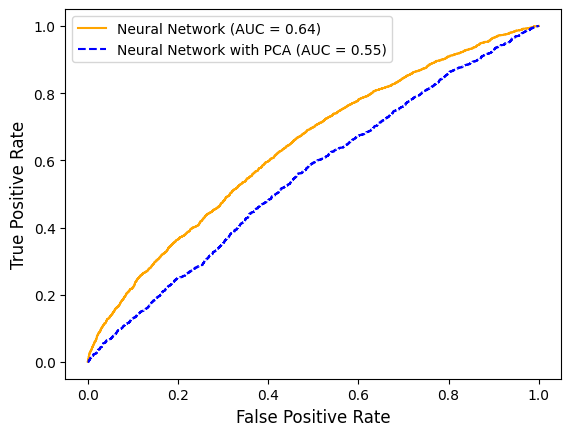

In [12]:
#computing ROC and AUC for neural network model with pca
X_test_probs_pca = best_nn_model_pca.predict(X1_test_pca).ravel()  
lr_fpr_pca, lr_tpr_pca, _ = roc_curve(y1_val, X_test_probs_pca, pos_label=1)
lr_auc_pca = roc_auc_score(y1_val, X_test_probs_pca)
print("The AUC score for this logistic regression model is", lr_auc_pca)

#computing ROC and AUC for neural network model alone
X_test_probs = best_nn_model.predict(X_test).ravel()  # Model predicted probabilities
lr_fpr, lr_tpr, _ = roc_curve(y_test, X_test_probs, pos_label=1)
lr_auc = roc_auc_score(y_test, X_test_probs)
print("The AUC score for this logistic regression model is", lr_auc)

#comparing ROC curve for neural network vs neural network and PCA
plt.plot(lr_fpr, lr_tpr, label=f'Neural Network (AUC = {lr_auc:.2f})', color='orange')
plt.plot(lr_fpr_pca, lr_tpr_pca, label=f'Neural Network with PCA (AUC = {lr_auc_pca:.2f})', color='blue', linestyle='--')
plt.legend()
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.savefig("neural_networks_auc.png", dpi = 300)



In [13]:
#transforming testing set onto PCA space
X1_tested_pca= pca.transform(X1_test)

/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [14]:
#testing and evaluating performance of PCA + neural network on original set
y_pred_pca_v = best_nn_model_pca.predict(X1_tested_pca)
y_pred_val_pca_v = (y_pred_pca_v > 0.47).astype(int)


#accuracy and classification report
print("Test Accuracy:", accuracy_score(y1_test, y_pred_val_pca_v))
print("Classification Report:\n", classification_report(y1_test, y_pred_val_pca_v))

1073/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
Test Accuracy: 0.1112211894285964
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     30502
           1       0.11      1.00      0.20      3817

    accuracy                           0.11     34319
   macro avg       0.06      0.50      0.10     34319
weighted avg       0.01      0.11      0.02     34319



/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/athul_09/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


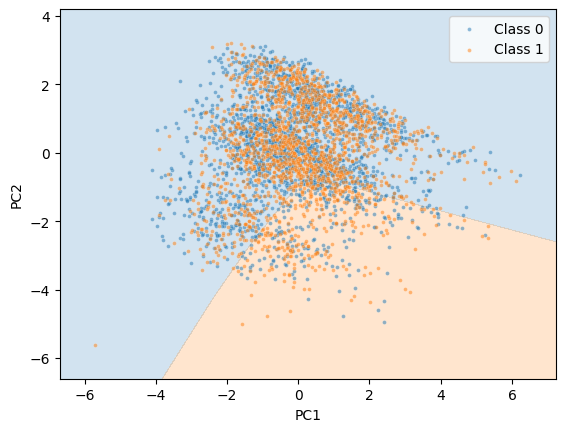

In [15]:
#creating a grid space based on PCA space from testing sets - allows to create boundaries needed
xx, yy = np.meshgrid(
    np.linspace(X1_test_pca[:, 0].min() - 1, X1_test_pca[:, 0].max() + 1, 200),
    np.linspace(X1_test_pca[:, 1].min() - 1, X1_test_pca[:, 1].max() + 1, 200)
)

#flattening the grid to make proper predictions of outcomes
grid = np.c_[xx.ravel(), yy.ravel()]

#making predictions based on neural network model with PCA
Z = best_nn_model_pca.predict(grid)  
Z = Z.reshape(xx.shape)

#plotting contours that are the decision grid space for the plot - represents classification
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2, colors=['tab:blue', 'tab:orange'])

#scatter plot of the actual data points - these are not readmitted vs readmitted
sns.scatterplot(x=X1_test_pca[y1_val == 0][:, 0], y=X1_test_pca[y1_val == 0][:, 1], 
                s=8, alpha=0.5, label="Class 0", color='tab:blue')
sns.scatterplot(x=X1_test_pca[y1_val == 1][:, 0], y=X1_test_pca[y1_val == 1][:, 1], 
                s=8, alpha=0.5, label="Class 1", color='tab:orange')

#plotting decision boundary plot
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig("nn_pca.png", dpi=300)